# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



---
# Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

def get_path_of_images(images_type):
    """
    Returns a list of paths of images that 
    matches the intended input type (images_type).
    
    Parameters:
        - images_type: Selector of the images to be used
        
    Output:
        - list of paths of the images
    """
    # Make list of path of images
    if images_type == 'Camera_Calibration':
        return glob.glob('./camera_cal/calibration*.jpg')
    

def display_multiple_images(images, grid_size, fig_size, titles = None):
    """
    Display multiple figures, each figure may have a
    title.
    
    Parameters:
        - images: Images to be displayed
        - grid_size: Size of the grid of figures
        - fig_size: Size of each figure on the grid
        - titles: Figure titles (optional)
    """
    rows, cols = grid_size
    fig,axs = plt.subplots(rows, cols, figsize = fig_size)
    axs = axs.ravel()
    for idx, img in enumerate(images):
        axs[idx].axis('off')
        if titles:
            axs[idx].set_title(titles[idx], fontsize = 15)
        axs[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                           

def get_matrices_of_points(images_path, n_corners_x, n_corners_y):
    """
    Retrieves the matrices of object points (3D points in real worrld space)
    and image points (2D points in image plane) that are required for furhter
    calibration steps.
    
    Parameters:
        - images_path: Paths of the images that will be used for calibration
        - n_corners_x: Number of corners on the chessboard in the x coordinate
        - n_corners_y: Number of corners on the chessboard in the y coordinate
        
    Output:
        - objpoints: 3D points in real world space
        - imgpoints: 2D points in image plane
        
    """
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((n_corners_y * n_corners_x, 3), np.float32)
    objp[:,:2] = np.mgrid[0:n_corners_x, 0:n_corners_y].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for i, fname in enumerate(images_path):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (n_corners_x, n_corners_y), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            # img = cv2.drawChessboardCorners(img, (n_corners_x, n_corners_y), corners, ret)
            
    return objpoints, imgpoints


def calibrate_camera(test_image_path, n_corners_x, n_corners_y):
    """
    Returns the camera matrix and distortion coefficients.
    
    Parameters:
        - test_image_path: Used to load an image and get the image dimensions
        - n_corners_x: Number of corners on the chessboard in the x coordinate
        - n_corners_y: Number of corners on the chessboard in the y coordinate
        
    Output:
        - mtx: Camera matrix
        - dis: Distortion coefficients
    """
    # Get paths of calibration images
    images_path = get_path_of_images('Camera_Calibration')
    # Get matrices of points
    objpoints, imgpoints = get_matrices_of_points(images_path, n_corners_x, n_corners_y)
    
    # Get size of the test image
    img = cv2.imread(test_image_path)
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "./camera_cal/calibration.p", "wb" ) )
    
    return mtx, dist
    

def undistort_image(img, mtx, dist):
    """
    Undistort a given image using a camera matrix and 
    distortion coefficients.
    
    Parameters:
        - img: Original image
        - mtx: Camera matrix
        - dis: Distortion coefficients
        
    Output: 
        - undistorted_image: Undistorted image
    """
    # Undistort image using camera matrix and coefficients
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted_image


### Visualize calibration and distortion

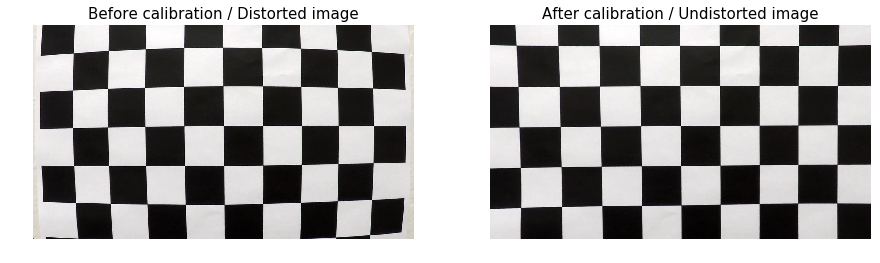

In [11]:
# Chessboard size
n_corners_x = 9
n_corners_y = 6

# Image to undistort
test_image_path = './camera_cal/calibration1.jpg'
test_image = cv2.imread(test_image_path)

# Camera calibration (the test_image_path is only used to get the shape of the image)
mtx, dist = calibrate_camera(test_image_path, n_corners_x, n_corners_y)
# Undistort an image
img = undistort_image(test_image, mtx, dist)

# Plot distorted and undistorted images
titles = ['Before calibration / Distorted image', 'After calibration / Undistorted image']
display_multiple_images([test_image, img], (1, 2), (15, 5), titles = titles)

### Undistortion applied to test image

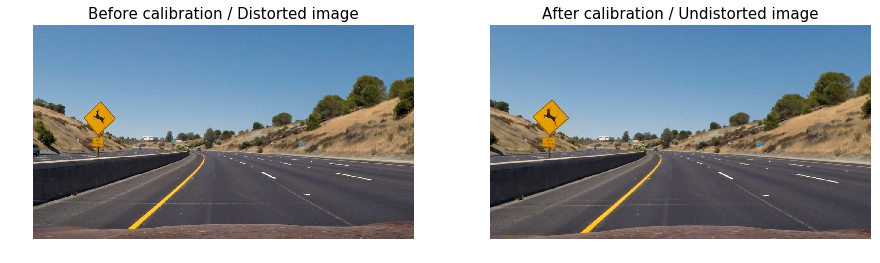

In [12]:
test_image_path = "./test_images/test2.jpg"
test_image = cv2.imread(test_image_path)

# Undistort an image
img = undistort_image(test_image, mtx, dist)

# Plot distorted and undistorted images
titles = ['Before calibration / Distorted image', 'After calibration / Undistorted image']
display_multiple_images([test_image, img], (1, 2), (15, 5), titles = titles)

---
# Perspective Transform

In [2]:
def get_source_destination_points(img_width, img_height):
    """
    Return an array of selected points (x and y positions) 
    in the source image, and an array of the new expected
    positions for the points in the destination image.
    
    Parameters:
        - img_width: Width of the image
        - img_height: Height of the image
        
    Output:
        - Arrays of source and destination points
    """
    # Source points
    bottom_left = (258, 682)
    top_left = (575, 464)
    top_right = (707, 464)
    bottom_right = (1049, 682)
    source = np.float32([ bottom_left, top_left, top_right, bottom_right ])
    
    # Destination points
    bottom_left = (450, img_height)
    top_left = (450, 0)
    top_right = (img_width - 450, 0)
    bottom_right = (img_width - 450, img_height)
    destination = np.float32([ bottom_left, top_left, top_right, bottom_right ])
    
    return source, destination


def perspective_transform(img):
    """
    Returns the warped image, i.e. the image after
    the perspective transform.
    
    Parameters:
        - img: Original iamge
        
    Output:
        - warped: Image after perspectice transform
    """
    # Get image size
    height = img.shape[0]
    width = img.shape[1]
    
    # Get source and destination points
    source_points, destination_points = get_source_destination_points(width, height)
    
    # Get transformation and inverse matrices
    transformation_matrix = cv2.getPerspectiveTransform(source_points, destination_points)
    inverse_matrix = cv2.getPerspectiveTransform(destination_points, source_points)
    
    # Perform transformation
    warped = cv2.warpPerspective(img, transformation_matrix, (width, height), flags = cv2.INTER_LINEAR)
    
    return warped, transformation_matrix, inverse_matrix
    

### Apply perspective transformation to test image

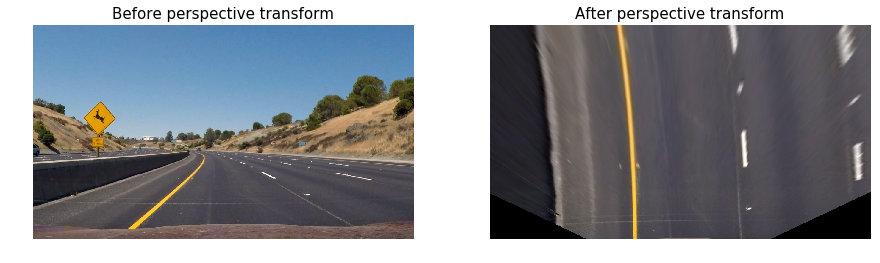

In [13]:
test_image_path = "./test_images/test2.jpg"
test_image = cv2.imread(test_image_path)

# Perspective transformation
warped, *matrices = perspective_transform(img)

# Plot original and warped images
titles = ['Before perspective transform', 'After perspective transform']
display_multiple_images([test_image, warped], (1, 2), (15, 5), titles = titles)

---
# Threshold

In [3]:
def sobel_binaries(img, sobel_kernel, threshold):
    """
    Returns binary images of sobel outcomes under
    different criteria
    
    Parameters:
        - img: Original image
        - sobel_kernel: Size of the sobel kernel to be used
        - threshold: Threshold range
        
    Output:
        - abs_sobelx: Binary of absolute value of sobel operator in the x axis
        - abs_sobely: Binary of absolute value of sobel operator in the y axis
        - mag_sobel: Binary of magnitude of sobel operator
        - direction_sobel: Binary of direction of sobel operator
    """
    # Sobel absolute binary images
    abs_sobelx, abs_sobely = sobel_absolute(img, sobel_kernel, threshold)
    
    # Sobel magnitude binary
    mag_sobel = sobel_magnitude(img, sobel_kernel, threshold)
    
    # Sobel direction
    direction_sobel = sobel_direction(img, sobel_kernel)
    
    return abs_sobelx, abs_sobely, mag_sobel, direction_sobel


def sobel_operator(img, sobel_kernel):
    """
    Returns images of sobel operator applied to each
    axis in a given image
    
    Parameters:
        - img: Original image
        - sobel_kernel: Size of the sobel kernel
        
    Output:
        - sobelx: Sobel operator applied to the x axis
        - sobely: Sobel operator applied to the y axis
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    return sobelx, sobely
    

def sobel_absolute(img, sobel_kernel, threshold):
    """
    Returns binary images of the sobel absolute values in each
    axis using a threshold as discriminator.
    
    Parameters:
        - img: Original image
        - sobel_kernel: Size of the sobel kernel
        - threshold: Threshold range
        
    Output:
        - sxbinary: Binary image of sobel absolute operator in the x axis
        - sybinary: Binary image of sobel absolute operator in the y axis
    """
    # Apply sobel operator
    sobelx, sobely = sobel_operator(img, sobel_kernel)
    # Take absolute values of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Scale to 8-bit
    abs_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    abs_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))
    # Placeholders
    sxbinary = np.zeros_like(abs_sobelx)
    sybinary = np.zeros_like(abs_sobelx)
    # Binary images
    threshold_min, threshold_max = threshold
    sxbinary[(abs_sobelx >= threshold_min) & (abs_sobelx <= threshold_max)] = 1
    sybinary[(abs_sobely >= threshold_min) & (abs_sobely <= threshold_max)] = 1
    
    return sxbinary, sybinary


def sobel_magnitude(img, sobel_kernel, threshold):
    """
    Returns binary images of the sobel absolute values in each
    axis using a threshold as discriminator.
    
    Parameters:
        - img: Original image
        - sobel_kernel: Size of the sobel kernel
        - threshold: Threshold range
        
    Output:
        - mag_binary: Binary image of sobel magnitude
    """
    # Apply sobel operator
    sobelx, sobely = sobel_operator(img, sobel_kernel)
    # Calculate the magnitude
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    mag_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))
    # Binary image
    threshold_min, threshold_max = threshold
    mag_binary = np.zeros_like(mag_sobel)
    mag_binary[(mag_sobel >= threshold_min) & (mag_sobel <= threshold_max)] = 1
    
    return mag_binary


def sobel_direction(img, sobel_kernel):
    """
    Returns binary image of direction at each pixel using the
    sobel operator (intended only for thresholding purposes, 
    all the information about direction will be lost after
    binarization).
    
    Parameters:
        - img: Original image
        - sobel_kernel: Size of the sobel kernel
        
    Output:
        - dir_binary: Binary image of sobel direction
    """
    # Apply sobel operator
    sobelx, sobely = sobel_operator(img, sobel_kernel)
    # Calculate direction using absolute values
    sobel_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Binary image
    threshold_min, threshold_max = ( 0, np.pi/4 )
    dir_binary = np.uint8(np.zeros_like(sobel_dir))
    dir_binary[(sobel_dir >= threshold_min) & (sobel_dir <= threshold_max)] = 1
    
    return dir_binary
    

def color_space_transform(img):
    """
    Returns a given image in multiple colorspaces.
    
    Parameters:
        - img: Original image
        
    Output:
        - rgb: Image in the RGB colorspace
        - hls: Image in the HLS colorspace
        - lab: Image in the LAB colorspace
    """
    # Colorspace transforms
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    return rgb, hls, lab


def threshold_combined(img, sobel_kernel, sobel_threshold, color_threshold):
    """
    Returns a binary image, made from combining
    sobel and color thresholds.
    
    Parameters:
        - img: Original image
        - sobel_kernel: Size of the sobel kernel
        - sobel_threshold: Threshold range for sobel operator
        - color_threshold: Threshold for colorspaces
        
    Output:
        - binary_combined: Binary image made from sobel and 
                           colorspaces binaries
    """
    # Get sobel images
    absx, *_ = sobel_binaries(img, sobel_kernel, sobel_threshold)
    
    # Get colorspaces
    _, hls, lab = color_space_transform(img)
    # Take S and B channel
    hls = hls[:,:,2]
    lab = lab[:,:,2]
    # Binarize channels
    threshold_min, threshold_max = color_threshold
    binary_hls = np.zeros_like(absx)
    binary_lab = np.zeros_like(absx)
    binary_hls[(hls >= threshold_min) & (hls <= threshold_max)] = 1
    binary_lab[(lab >= threshold_min) & (lab <= threshold_max)] = 1
    
    # Combine binaries
    binary_combined = np.zeros_like(absx)
    binary_combined[(absx == 1) | (binary_hls == 1) | (binary_lab == 1)] = 1
    
    return binary_combined
    

### Sobel

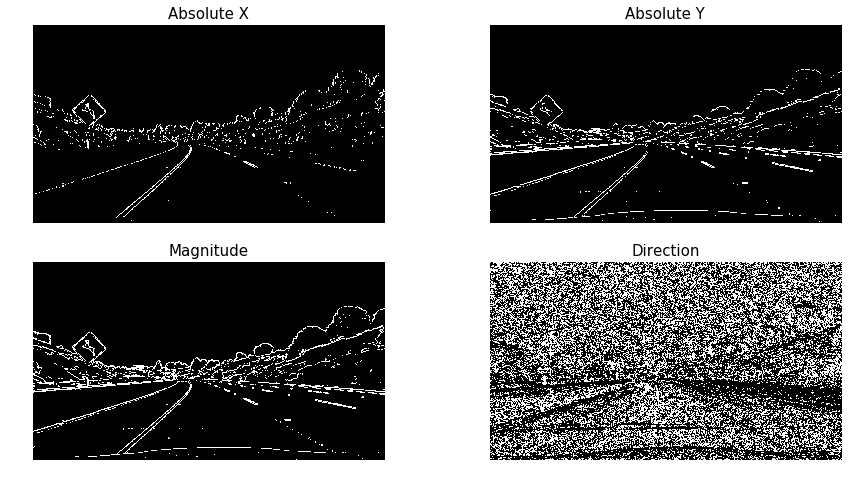

In [14]:
test_image_path = "./test_images/test2.jpg"
test_image = cv2.imread(test_image_path)

# Sobel binary images
images = np.asarray(sobel_binaries(img, 5, (40, 255)))
images = images * 255

# Plot images
titles = ["Absolute X", "Absolute Y", "Magnitude", "Direction"]
display_multiple_images(images, (2, 2), (15, 8), titles)
                       

### Colorspaces

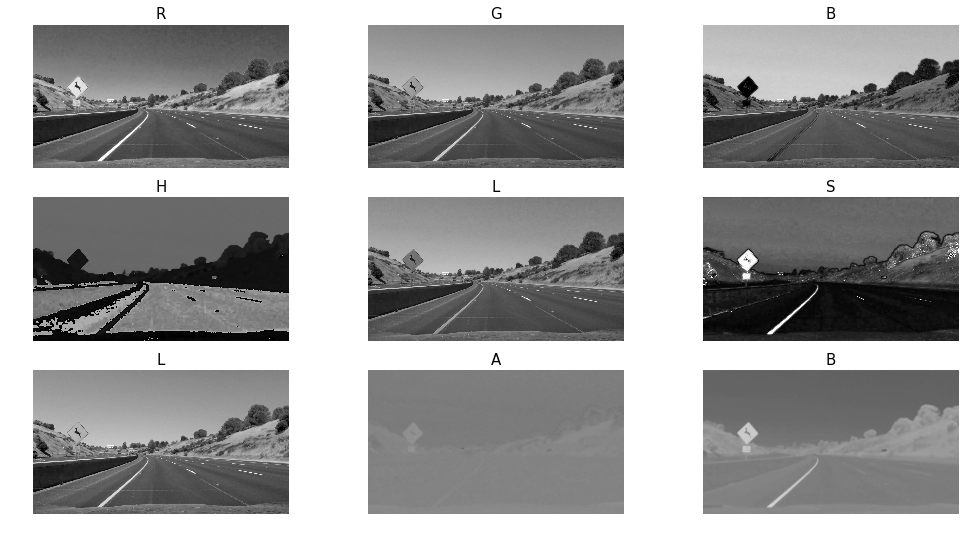

In [15]:
test_image_path = "./test_images/test2.jpg"
test_image = cv2.imread(test_image_path)

# Color space transform
images = color_space_transform(test_image)

# Keep track of all independent image channels
img_channels = []
titles = ["R", "G", "B", "H", "L", "S", "L", "A", "B"]
for image in images:
    for channel in range(image.ndim):
        img_channels.append(image[:,:,channel])
        
display_multiple_images(img_channels, (3, 3), (17, 9), titles)

### Applying combined thresholding

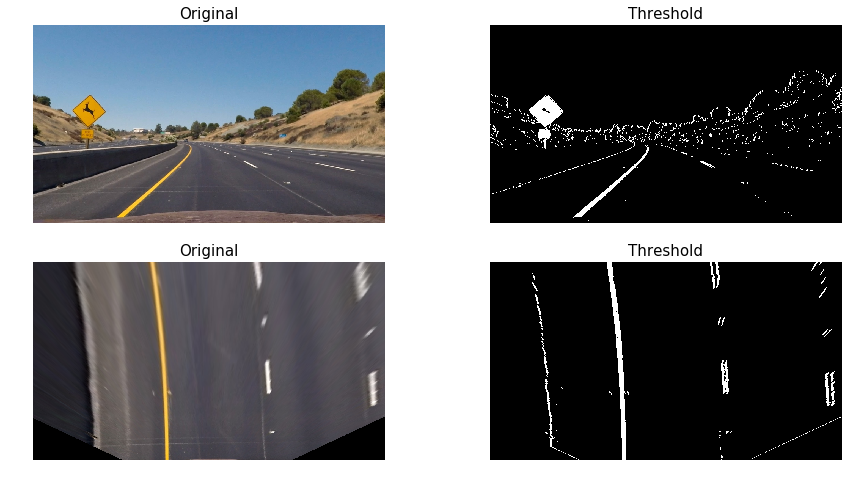

In [16]:
# Apply combined thresholds to test and warped image
sobel_threshold = (40, 255)
color_threshold = (180, 255)
binary_img = threshold_combined(img, 5, sobel_threshold, color_threshold)
binary_warped = threshold_combined(warped, 5, sobel_threshold, color_threshold)

# Plot
images = [img, binary_img * 255, warped, binary_warped * 255]
titles = ["Original", "Threshold"] * 2
display_multiple_images(images, (2, 2), (15, 8), titles)

---
# Polynomial Fit

In [4]:
def find_base_points(img):
    """
    Returns a histogram and the base points for the left
    and right lines
    
    Parameters:
        - img: Original binary warped image
        
    Output:
        - histogram: Histogram of the bottom half of the image
        - leftx_base: Base point of the left line
        - rightx_base: Base point of the right line
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0] // 2:,:], axis = 0)
    # Find the peak of the left and right halves of the histogram
    # these will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    # Find middle points between the edges and the half to avoid noise and outliers
    edge_offset = np.int(midpoint // 2)
    leftx_base = np.argmax(histogram[edge_offset : midpoint]) + edge_offset
    rightx_base = np.argmax(histogram[midpoint : (midpoint + edge_offset)]) + midpoint
    
    return histogram, leftx_base, rightx_base


def find_lane_pixels(img, n_windows, window_width, min_pixels):
    """
    Returns a histogram and the base points for the left
    and right lines
    
    Parameters:
        - img: Original binary warped image
        - n_windows: Number of windows to use
        - window_width: Width of each window +/- margin
        - min_pixels: Minimum number of pixels found to recenter window
        
    Output:
        - out_img: Output image (windows drawn)
        - leftx: Positions of all pixels belonging to the left line in the x axis
        - lefty: Positions of all pixels belonging to the left line in the y axis
        - rightx: Positions of all pixels belonging to the right line in the x axis
        - righty: Positions of all pixels belonging to the right line in the y axis
    """
    # Get histogram and base points
    histogram, leftx_base, rightx_base = find_base_points(img)
    
    # Output image
    out_img = np.dstack((img * 255, img * 255, img * 255))
    
    # Set height of winwdows
    window_height = np.int(img.shape[0] // n_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in n_windows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - window_width
        win_xleft_high = leftx_current + window_width
        win_xright_low = rightx_current - window_width
        win_xright_high = rightx_current + window_width
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,255), 2) # Swap red channel to blue
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  
                           (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > min_pixels:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > min_pixels:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        print("Error when trying to concatenate array")
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    return out_img, leftx, lefty, rightx, righty


def fit_polynomial(img, n_windows, window_width, min_pixels):
    """
    Fits a second degree polynomial in the points founded for
    the left and right line. Returns lines points and an output 
    image with the windows and colored points drawn for each line.
        - Left line (Green windows, red points)
        - Right line (Yellow windows, blue points)
    
    Parameters:
        - img: Original binary warped image
        - n_windows: Number of windows to use
        - window_width: Width of each window +/- margin
        - min_pixels: Minimum number of pixels found to recenter window
        
    Output:
        - out_img: Output image (windows drawn and points colored)
        - left_fit: Coefficients of the polynomial (Ax^2 + Bx + C) 
                    applied to points in the left line
        - right_fit: Coefficients of the polynomial (Ax^2 + Bx + C) 
                    applied to points in the right line
    """
    # Find our lane pixels first
    out_img, leftx, lefty, rightx, righty = find_lane_pixels(img, n_windows, 
                                                             window_width, min_pixels)

    # Fit a second order polynomial to each using `np.polyfit` (Ax^2 + Bx + C)
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty**2 + 1 * ploty
        right_fitx = 1 * ploty**2 + 1 * ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    # plot function swap the channels, so we need to swap here
    out_img[lefty, leftx] = [0, 0, 255] # Red swap
    out_img[righty, rightx] = [255, 0, 0] # Blue swap

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='red')
    #plt.plot(right_fitx, ploty, color='blue')

    return out_img, left_fit, right_fit


def search_around_poly(img, left_fit, right_fit, margin = 100):
    """
    This function uses the previous frame polynomials to create
    a customized region of interest for the current frame, i.e.
    we don't need to blindly search again.
    
    Parameters:
        - img: Original binary warped image
        - left_fit: Coefficients of the polynomial (Ax^2 + Bx + C) 
                    applied to points in the left line in the previous frame
        - right_fit: Coefficients of the polynomial (Ax^2 + Bx + C) 
                     applied to points in the right line in the previous frame
        - margin: Width of the margin +/- around the previous polynomial to search
        
    Output:
        - result: Output image with ROIs drawn
    """
    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function
    # Hint: consider the window areas for the similarly named variables
    # in the previous quiz, but change the windows to our new search area
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty**2 + 1 * ploty
        right_fitx = 1 * ploty**2 + 1 * ploty
        
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img)) * 255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 0, 255] # Swap red
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0] # Swap blue

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, 
                                                          ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, 
                                                                    ploty])))])
    left_line_pts = np.hstack((left_line_window1, 
                               left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, 
                                                           ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, 
                                                                     ploty])))])
    right_line_pts = np.hstack((right_line_window1, 
                                right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    return result, left_fit, right_fit

### Apply polynomial fit

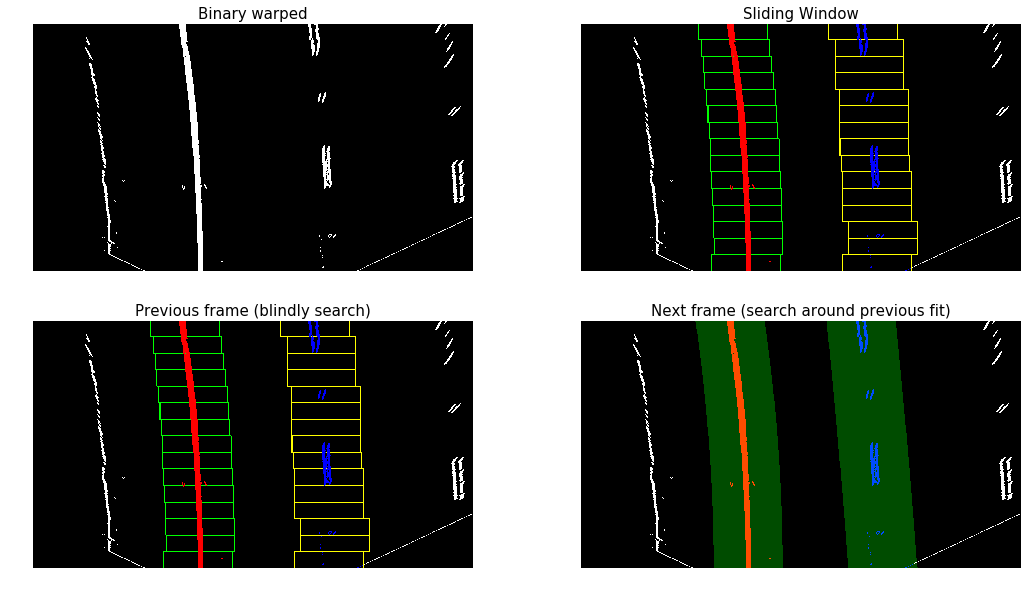

In [17]:
# Parameters
n_windows = 15
window_width = 100
min_pixels = 40
margin_polynomial_search = 100

# Fit polynomials
out_img, left_fit, right_fit = fit_polynomial(binary_warped, n_windows, window_width, min_pixels)
next_frame, left_fit, right_fit = search_around_poly(binary_warped, left_fit, right_fit, margin_polynomial_search)

# Plot
titles = ["Binary warped", "Sliding Window", "Previous frame (blindly search)", 
          "Next frame (search around previous fit)"]
display_multiple_images([binary_warped * 255, out_img, out_img, next_frame], 
                        (2, 2), (18, 10), titles)

---
# Curvature and Distance

In [23]:
def measure_curvature_and_distance(img, left_fit, right_fit):
    """
    Returns the radius of curvature in meters for both lane
    lines as long as the distance from center of the car.
    
    Parameters:
        - img: Original binary warped image
        - left_fit: Coefficients of the polynomial (Ax^2 + Bx + C) 
        - right_fit: Coefficients of the polynomial (Ax^2 + Bx + C) 
        
    Output:
        - left_curve_rad: Radius of curvature of left lane line
        - right_curve_rad: Radius of curvature of right lane line
        - center_dist: Distance from center of the car
    """
    # Define conversions in x and y from pixels space to meters
    # Meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    ym_per_pix = 3.048 / 100 
    # Meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    xm_per_pix = 3.7 / 378
    
    # Define y-value where we want radius of curvature
    # We will choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_point = np.max(ploty)
    
    # Calculate the radius of curvature
    left_curve_rad = ((1 + (2 * left_fit[0] * y_point * ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2 * left_fit[0])
    right_curve_rad = ((1 + (2 * right_fit[0] * y_point * ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2 * right_fit[0])
    
    # Distance from center is image x midpoint - mean of left_fit and right_fit intercepts 
    if right_fit is not None and left_fit is not None:
        # Height of image
        height = img.shape[0]
        # Car is in the middle of x axis
        car_position = img.shape[1] / 2
        # Calculate lane center position
        left_fit_x_int = left_fit[0] * height**2 + left_fit[1] * height + left_fit[2]
        right_fit_x_int = right_fit[0] * height**2 + right_fit[1] * height + right_fit[2]
        lane_center_position = (right_fit_x_int + left_fit_x_int) / 2
        # Calculate distance from center
        center_dist = (car_position - lane_center_position) * xm_per_pix

    return left_curve_rad, right_curve_rad, center_dist



def unwarp_and_draw_path(img, binary_warped, left_fit, right_fit, inverse_matrix):
    """
    Returns a weighted image containing the original image and the path 
    delimited by the lane lines.
    
    Parameters:
        - img: Original color image (not warped)
        - binary_warped: Binary warped image
        - left_fit: Coefficients of the polynomial (Ax^2 + Bx + C) 
        - right_fit: Coefficients of the polynomial (Ax^2 + Bx + C) 
        - inverse_matrix: Inverse matrix of the perspective transform
        
    Output:
        - result: Weighted image made from the original and the 
                  unwarped image (path and lane lines drawn)
    """
    # Create a copy of the original imge
    out_img = np.copy(img)
    # If no fit then return the original image
    if left_fit is None or right_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    height, width = binary_warped.shape
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed = False, color=(0,0,255), thickness = 15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed = False, color=(255,0,0), thickness = 15)

    # Warp the blank back to original image space using inverse perspective matrix (inverse_matrix)
    unwarp = cv2.warpPerspective(color_warp, inverse_matrix, (width, height)) 
    # Combine the result with the original image
    result = cv2.addWeighted(out_img, 1, unwarp, 0.5, 0)
    
    return result


def draw_curvature_and_distance(img, curv_rad, center_dist):
    """
    Draws text (curvature radius and distance from center) in a 
    given image
    
    Parameters:
        - img: Original color image 
        - curv_rad: Curvature radius
        - center_dist: Distance from center 
        
    Output:
        - out_img: Image with the measures drawn
    """
    # Copy image
    out_img = img.copy()
    height = img.shape[0]
    
    text = 'Curve radius: ' + '{0:.2f}'.format(curv_rad) + "m"
    # Bottom left of the text box (oring)
    text_origin = (70, 90)
    font = cv2.FONT_HERSHEY_TRIPLEX   
    font_scale = 1
    font_color = (255, 255, 255)
    thickness = 2
    # Line type (FILLED, LINE_4, LINE_8, LINE_AA)
    line_type = cv2.LINE_AA
   
    # Place text on the output image
    cv2.putText(out_img, text, text_origin, font, font_scale, font_color, thickness, line_type)
    
    # Direction from center
    if center_dist > 0:
        direction = 'right'
    else:
        direction = 'left'
    
    text = '{0:.2f}'.format(np.absolute(center_dist)) + "m " + direction + " from center"
    text_origin = (70, 140)
    # Place text on the output image
    cv2.putText(out_img, text, text_origin, font, font_scale, font_color, thickness, line_type)
    
    return out_img
    


### Calculate curvature, distance and draw them

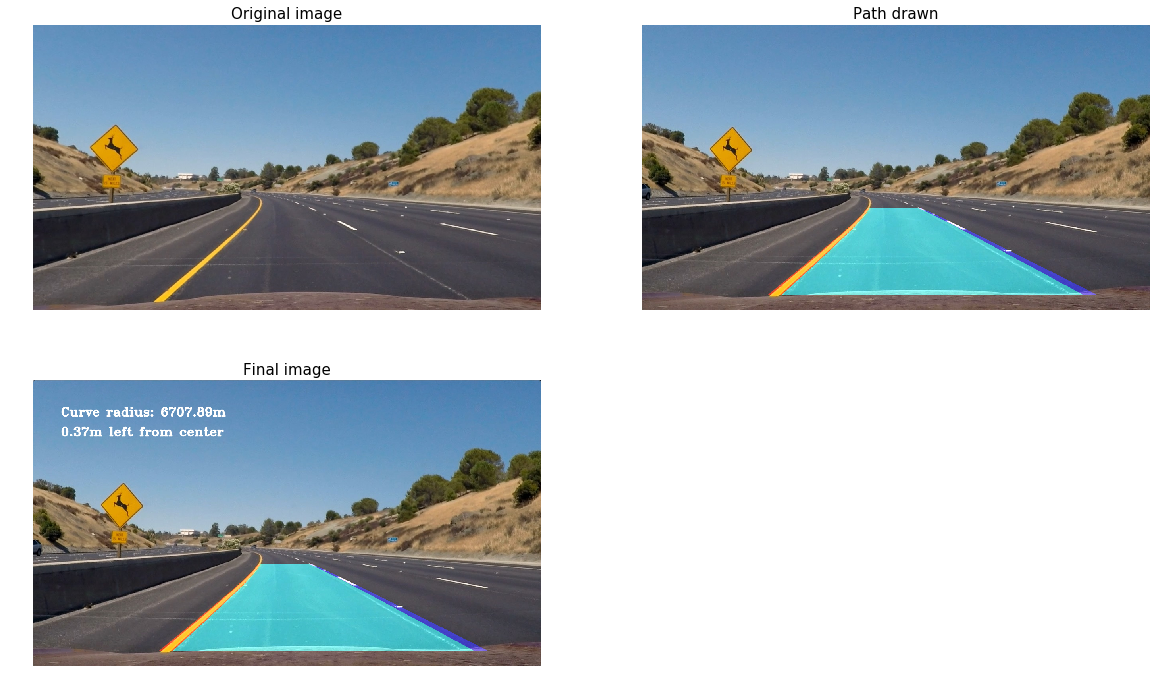

In [22]:
# Parameters
n_windows = 15
window_width = 100
min_pixels = 40
margin_polynomial_search = 100

# Get inverse matrix from perspective transfomr 
# (refer above to cell in the perspective transform section)
camera_matrix, inverse_matrix = matrices

# Fit polynomials
polynomial, left_fit, right_fit = fit_polynomial(binary_warped, n_windows, window_width, min_pixels)
path_drawn = unwarp_and_draw_path(test_image, binary_warped, left_fit, right_fit, inverse_matrix)
curve_left, curve_right, center_dist = measure_curvature_and_distance(binary_warped, left_fit, right_fit)

# Average curvature from both lines
curv_rad = (curve_left + curve_right) / 2
final = draw_curvature_and_distance(path_drawn, curv_rad , center_dist)

# Plot 
dummy_image = np.uint8(np.ones_like(final)) * 255
titles = ["Original image", "Path drawn", "Final image", ""]
display_multiple_images([img, path_drawn, final, dummy_image ], (2, 2), (20, 12), titles)

---
# Pipeline

### Line Class

In [37]:
"""
    Class to store properties and keep track of one
    lane line at each frame
    
    Members:
        - was_line_detected: Flag to indicate if a line was detected in the actual
                             frame so we can look around the polynomial in the next
                             one, skiping the sliding windows.
        - best_fit: Average of the previous 5 fits found, provides a smooth transition
        - fits: Array containing the 5 most recent fits
        - difference: Difference of polynomial coefficients between the best and 
                      actual ones, they're used to remove outliers
    """
class LaneLine:
    def __init__(self):
        self.was_line_detected = False
        self.best_fit = None
        self.fits = []
        self.difference = np.array([0, 0, 0], dtype = 'float')
        
    def add_fit(self, fit):
        """
        Update class members and adds a fit to the array if it is
        a valid one.
    
        Parameters:
            - fit: Polynomial fit to validate
        """
        if fit is not None:
            # If we already have one best, calculate differences
            if self.best_fit is not None:
                self.diff_left = abs(fit - self.best_fit)
            
            # Trigger flag if big difference on coefficients, shouldn't be that much from frame to frame
            big_difference = self.difference[0] > 0.001 or self.difference[1] > 1.0 or self.difference[2] > 100
            # Trigger flag if there are other fits
            are_fits = len(self.fits) > 0
            
            # If the difference is big and we have other fits, then dispose it (bad fit)
            if big_difference and are_fits:
                self.was_line_detected = False
            else:
                self.was_line_detected = True
                self.fits.append(fit)
                
                # Just keep previous 5 fits
                if len(self.fits) > 5:
                    self.fits = self.fits[1:]
                
                # Best fit is the average of the n fits
                self.best_fit = np.average(self.fits, axis = 0)
        
        # No fit found
        else:
            self.was_line_detected = False
            
            # Average fits if exist
            if len(self.fits) > 0:
                self.best_fit = np.average(self.fits, axis = 0)
                
        

### Build pipeline

In [38]:
def build_pipeline(img, 
                   mtx, 
                   dist,
                   sobel_kernel,
                   sobel_threshold,
                   color_threshold,
                   n_windows,
                   window_width,
                   min_pixels,
                   margin,
                   lane_width,
                   width_tolerance,
                   left_lane_line, 
                   right_lane_line):
    
    """
        Pipeline to be executed at every frame.
    
        Parameters:
            - img: Image of the actual frame
            - mtx: Camera matrix
            - dist: Distortion coefficients
            - sobel_kernel: Size of the sobel kernel 
            - sobel_threshold: Threshold values for sobel operator
            - color_threshold: Threshold values for colorspaces 
            - n_windows: Number of sliding windows to fit
            - window_width: Width of each window
            - min_pixels: Minimum number of pixels found to recenter window
            - margin: Width of the margin +/- around the previous polynomial to search
            - lane_width: Width of the lane in pixels
            - width_tolerance: Tolerance to invalidate fits
            - left_lane_line: Object to keep track of the left lane line
            - right_lane_line: Object to keep track of the right lane line
        """
    
    # Create copy of the image
    image = np.copy(img)
    
    # Undistort image
    undistorted_image = undistort_image(img, mtx, dist)
    
    # Perspective transform
    warped_image, t_matrix, inverse_matrix = perspective_transform(undistorted_image)
    
    # Thresholding
    binary_image = threshold_combined(warped_image, sobel_kernel, sobel_threshold, color_threshold)
    
    # If both lane lines were detected in the previous frame use search_around_poly
    if left_lane_line.was_line_detected and right_lane_line.was_line_detected:
        polynomial_image, left_fit, right_fit = search_around_poly(binary_image, 
                                                                   left_lane_line.best_fit, 
                                                                   right_lane_line.best_fit, 
                                                                   margin)
    # Otherwise use sliding window
    else:
        polynomial_image, left_fit, right_fit = fit_polynomial(binary_image, 
                                                               n_windows, 
                                                               window_width, 
                                                               min_pixels)
    # Invalidate both fits if difference in their x intercepts
    # (lane width) is not around the average, i.e. 350 px
    if left_fit is not None and right_fit is not None:
        # Calculate x intercept for fits
        height = img.shape[0]
        left_fit_x = left_fit[0] * height**2 + left_fit[1] * height + left_fit[2]
        right_fit_x = right_fit[0] * height**2 + right_fit[1] * height + right_fit[2]
        diff_x = abs(right_fit_x - left_fit_x)
        
        # Invalidate if difference greater than the tolerance
        if abs(lane_width - diff_x) > width_tolerance:
            left_fit = None
            right_fit = None
    
    # Add fits to lane line objects
    left_lane_line.add_fit(left_fit)
    right_lane_line.add_fit(right_fit)
    
    # Draw path and measurements using the best_fit (average of fits) for both lane lines
    if left_lane_line.best_fit is not None and right_lane_line.best_fit is not None:
        
        out_img = unwarp_and_draw_path(image, 
                                       binary_image, 
                                       left_lane_line.best_fit, 
                                       right_lane_line.best_fit, 
                                       inverse_matrix)
        
        curve_left, curve_right, center_dist = measure_curvature_and_distance(binary_image, 
                                                                              left_lane_line.best_fit, 
                                                                              right_lane_line.best_fit)
        curv_rad = (curve_left + curve_right) / 2
        out_img = draw_curvature_and_distance(out_img, curv_rad , center_dist)
    
    # Otherwise, return original image
    else:
        out_img = image
        
    return out_img

# Test on Videos

In [34]:
# Control variables

test_image_path = './camera_cal/calibration1.jpg'
# Chessboard size
n_corners_x = 9
n_corners_y = 6
mtx, dist =  calibrate_camera(test_image_path, n_corners_x, n_corners_y)

sobel_kernel = 5
sobel_threshold = (40, 255) 
color_threshold = (180, 255)
n_windows = 15
window_width = 100
min_pixels = 40
margin = 100
lane_width = 350
widht_tolerance = 100

In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Run previous cell before this one
def process_image(image):
    result = build_pipeline(image, 
                            mtx, 
                            dist,
                            sobel_kernel,
                            sobel_threshold,
                            color_threshold,
                            n_windows,
                            window_width,
                            min_pixels,
                            margin,
                            lane_width,
                            widht_tolerance,
                            left_lane_line, 
                            right_lane_line)
    return result

In [36]:
# Reset LaneLine objects before starting
left_lane_line = LaneLine()
right_lane_line = LaneLine()

project_output = 'Results/project_video.mp4'
clip1 = VideoFileClip('test_videos/project_video.mp4')
processed_video = clip1.fl_image(process_image)
%time processed_video.write_videofile(project_output, audio = False)

[MoviePy] >>>> Building video Results/project_video.mp4
[MoviePy] Writing video Results/project_video.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<07:07,  2.95it/s]


  0%|          | 2/1261 [00:00<07:22,  2.85it/s]


  0%|          | 3/1261 [00:01<07:08,  2.93it/s]


  0%|          | 4/1261 [00:01<06:33,  3.20it/s]


  0%|          | 5/1261 [00:01<06:22,  3.29it/s]


  0%|          | 6/1261 [00:01<06:28,  3.23it/s]


  1%|          | 7/1261 [00:02<06:39,  3.14it/s]


  1%|          | 8/1261 [00:02<06:24,  3.26it/s]


  1%|          | 9/1261 [00:02<05:44,  3.63it/s]


  1%|          | 10/1261 [00:02<05:21,  3.89it/s]


  1%|          | 11/1261 [00:03<05:10,  4.02it/s]


  1%|          | 12/1261 [00:03<05:31,  3.77it/s]


  1%|          | 13/1261 [00:03<05:10,  4.02it/s]


  1%|          | 14/1261 [00:03<05:16,  3.94it/s]


  1%|          | 15/1261 [00:04<05:27,  3.80it/s]


  1%|▏         | 16/1261 [00:04<05:33,  3.74it/s]


  1%|▏         | 17/1261 [00:04<05:44,  3.61it/s]


  1%|▏         | 18/1261 [00:05<05:24,  3.83it/s]


  2%|▏         | 19/1261 [0

KeyboardInterrupt: 